# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505177 sha256=2d861eb6d7c663d5ceae3fa43cb6a581cfa0f94df55d71254c26c410145cf380
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 100)

import numpy as np
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import cross_validate, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Archive/MIT_IDSS/Recommendation Systems/ratings_Electronics.csv', header=None)
df = data.copy()
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df.drop('timestamp', axis=1, inplace=True)
print(df.shape)
df.head()

(7824482, 3)


,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
print(df_final.shape)
df_final.head()

(65290, 3)


,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

df_final's shape : (65290,3)

### **Data types**

In [ ]:
# Check Data types and provide observations
display(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


None

- user_id : object type
- prod_id : object type
- rating : float type

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
user_id    0
prod_id    0
rating     0
dtype: int64


There is no missing data.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
rating_summary = df_final['rating'].describe()

print("Summary statistics of 'rating' variable:")
display(rating_summary.to_frame().T)

Summary statistics of 'rating' variable:


,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


The data is highly skewed towards positive ratings (4-5 stars).  

### **Checking the rating distribution**

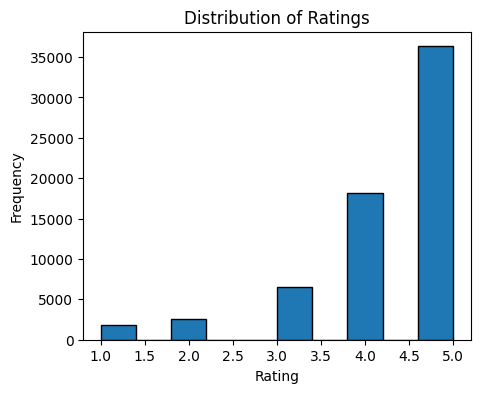

In [ ]:
# Create the bar plot and provide observations
plt.figure(figsize=(5, 4))
plt.hist(df_final['rating'], bins=10, edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

It is presumed that there are either few negative reviews for the products or that the products are those with high user satisfaction.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of total rows and number of unique users & items count
print(f"Total rows: {df_final.shape[0]}")
print(f"Unique users: {df_final['user_id'].nunique()}")
print(f"Unique products: {df_final['prod_id'].nunique()}")

Total rows: 65290
Unique users: 1540
Unique products: 5689


### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
top_users = df_final['user_id'].value_counts().reset_index().sort_values(by='count', ascending=False).head(10)

print("Top 10 users with the most ratings:")
display(top_users)

Top 10 users with the most ratings:


,user_id,count
0,ADLVFFE4VBT8,295
1,A3OXHLG6DIBRW8,230
2,A1ODOGXEYECQQ8,217
3,A36K2N527TXXJN,212
4,A25C2M3QF9G7OQ,203
5,A680RUE1FDO8B,196
6,A1UQBFCERIP7VJ,193
7,A22CW0ZHY3NJH8,193
8,AWPODHOB4GFWL,184
9,AGVWTYW0ULXHT,179


Some users have left a significantly large number of ratings, indicating that they play an important role in the dataset.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate average rating and count for each product
product_ratings = df_final.groupby('prod_id').agg({'rating': ['mean', 'count']}).reset_index()
product_ratings.columns = ['prod_id', 'avg_rating', 'rating_count']

# Create a dataframe with calculated average and count of ratings
# Sort the dataframe by average of ratings in the descending order
product_ratings = product_ratings.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
print("Top 5 products based on average rating:")
display(product_ratings.head())

Top 5 products based on average rating:


,prod_id,avg_rating,rating_count
5688,B00LGQ6HL8,5.0,5
2302,B003DZJQQI,5.0,14
3443,B005FDXF2C,5.0,7
5554,B00I6CVPVC,5.0,7
4810,B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def recommend_top_products(data, min_interactions, top_n):

    # Filter products with at least `min_interactions` ratings
    filtered_products = data[data['rating_count'] >= min_interactions]

    # Sort by average rating
    top_products = filtered_products.sort_values(by='avg_rating', ascending=False).head(top_n)
    return top_products

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_5_products_50 = recommend_top_products(product_ratings, min_interactions=50, top_n=5)
print("Top 5 products with at least 50 ratings:")
display(top_5_products_50)

Top 5 products with at least 50 ratings:


,prod_id,avg_rating,rating_count
1594,B001TH7GUU,4.871795,78
2316,B003ES5ZUU,4.864130,184
1227,B0019EHU8G,4.855556,90
3877,B006W8U2MU,4.824561,57
850,B000QUUFRW,4.809524,84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_5_products_100 = recommend_top_products(product_ratings, min_interactions=100, top_n=5)
print("Top 5 products with at least 100 ratings:")
display(top_5_products_100)

Top 5 products with at least 100 ratings:


,prod_id,avg_rating,rating_count
2316,B003ES5ZUU,4.864130,184
781,B000N99BBC,4.772455,167
2073,B002WE6D44,4.770000,100
4126,B007WTAJTO,4.701220,164
2041,B002V88HFE,4.698113,106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
from collections import defaultdict

def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))  # rating scale = 1~5

# Loading the rating dataset
rating_data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(rating_data, test_size=0.2)  # test data : 20%

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import accuracy

# Declaring the similarity options
sim_options = {
    'name': 'cosine',    # cosine similarity
    'user_based': True   # user_based
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
knn_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
knn_model.fit(trainset)

# Make predictions on the test data
predictions = knn_model.test(testset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(knn_model, k=10, threshold=3.5)

RMSE: 1.0188
Precision:  0.851
Recall:  0.855
F_1 score:  0.853


Model Performance:  
- Precision, Recall, and F1-score are all above 0.85, indicating high performance.
- RMSE is relatively low (1.0188), reflecting good prediction accuracy.

Conclusion:
- The model, utilizing user-user cosine similarity, delivers high-quality recommendations.
- With both high precision and recall, the system is likely to provide high user satisfaction.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'  # user_id
product_id = '1400501466'   # product_id

# Predict rating
predicted_rating = knn_model.predict(user_id, product_id)

print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.294264052688007


The predicted rating is 4.2943.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
unique_users = df_final[df_final['prod_id'] != '1400501466']['user_id'].unique()

print(f"Number of users who have not seen the product 1400501466: {len(unique_users)}")

Number of users who have not seen the product 1400501466: 1540


In [ ]:
user_id_to_check = "A34BZM6S9L7QI4"

if user_id_to_check not in unique_users:
    print(f"User {user_id_to_check} is NOT in the list.")
else:
    print(f"User {user_id_to_check} IS in the list.")

User A34BZM6S9L7QI4 IS in the list.


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

predicted_rating = knn_model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 3.0


The predicted rating is 3.0.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
from surprise.model_selection import GridSearchCV

# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [20, 30, 40, 50],  # Neighbors
    'min_k': [1, 5, 10],    # minimum k
    'sim_options': {
        'name': ['cosine', 'pearson', 'msd'],
        'user_based': [True]  # user based
    },
    'verbose': [False]
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
gs.fit(rating_data)

# Best RMSE score
print(f"Best RMSE score: {gs.best_score['rmse']}")

# Combination of parameters that gave the best RMSE score
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE score: 0.9700912177248046
Best parameters: {'k': 50, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}, 'verbose': False}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
optimal_sim_options = {
    'name': 'cosine',
    'user_based': True,
    'verbose': False
}

# Creating an instance of KNNBasic with optimal hyperparameter values
final_model = KNNBasic(k=50, min_k=5, sim_options=optimal_sim_options)

# Training the algorithm on the trainset
final_model.fit(trainset)

# Making predictions on the test data
final_predictions = final_model.test(testset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(final_model, k=10, threshold=3.5)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9612
Precision:  0.844
Recall:  0.893
F_1 score:  0.868


RMSE: 0.9612
- The average prediction error is less than 1 point.  

Precision: 0.844
- Approximately 84.4% of the recommended items are actually relevant.  

Recall: 0.893
- About 89.3% of the relevant items were recommended.  

F1-Score: 0.868
- The harmonic mean of Precision and Recall.
- This shows that the model maintains a good balance between precision and recall.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predict the rating using the optimized model
predicted_rating = final_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.294264052688007


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predict the rating using the optimized model
predicted_rating = final_model.predict(user_id, product_id)

# Display the predicted rating
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.294264052688007


- The predicted rating for user A3LDPF5FMB782Z and product 1400501466 in the baseline model was 4.294264052688007, and the predicted rating in the optimized model was also 4.294264052688007, which remained the same.

- The predicted rating for user A34BZM6S9L7QI4 and product 1400501466 in the baseline model was 3.0, while the optimized model predicted a higher rating of 4.294264052688007.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user

# internal user_id
inner_user_id = 0

# get the list of 5 nearest neighbors
similar_users = final_model.get_neighbors(inner_user_id, k=5)

# [rint the list of similar users
print(f"top 5 similar users to the user with inner id {inner_user_id}: {similar_users}")

top 5 similar users to the user with inner id 0: [14, 19, 21, 23, 24]


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
user_id = "A3LDPF5FMB782Z"
top_n = 5

recommended_items = get_recommendations(df_final, user_id, top_n, final_model)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
# recommendations_df
recommendations_df = pd.DataFrame(recommended_items, columns=["prod_id", "predicted_ratings"])

# Display the recommendations dataframe
print(recommendations_df)

      prod_id  predicted_ratings
0  B00004Z5M1                  5
1  B0001CNMFM                  5
2  B00020S7XK                  5
3  B0002XQJFA                  5
4  B000AJIF4E                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',      # cosine similarity
    'user_based': False,    # item based
    'verbose':False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
knn_item_model = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
knn_item_model.fit(trainset)
item_predictions = knn_item_model.test(testset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(knn_item_model, k=10, threshold=3.5)

RMSE: 1.0199
Precision:  0.829
Recall:  0.845
F_1 score:  0.837


- The item-item collaborative filtering model achieves a good balance between Precision (0.829) and Recall (0.845).
- The F1 Score (0.837) indicates that the model performs well in balancing Precision and Recall.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

predicted_rating = knn_item_model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.294264052688007


The predicted rating is 4.29

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

predicted_rating = knn_item_model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.75


The predicted rating is 4.75

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]  # Item-item similarity
    },
    'verbose': [False]
}

# Performing 3-fold cross validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
grid_search.fit(rating_data)

# Find the best RMSE score
print(f"Best RMSE score: {grid_search.best_score['rmse']}")

# Find the combination of parameters that gave the best RMSE score
print(f"Best parameters: {grid_search.best_params['rmse']}")

Best RMSE score: 0.9749512947352916
Best parameters: {'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}, 'verbose': False}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {
    'name': 'msd',       # optimal similarity measure
    'user_based': False, # item-item similarity
    'verbose': False
}

# Creating an instance of KNNBasic with optimal hyperparameter values
final_model_item_item = KNNBasic(k=30, min_k=6, sim_options=sim_options, random_state=1)

# Training the algorithm on the trainset
final_model_item_item.fit(trainset)
predictions_item_item = final_model_item_item.test(testset)

# Let us compute precision@k and recall@k, f1_score and RMSE
rmse = accuracy.rmse(predictions_item_item, verbose=True)
precision_recall_at_k(final_model_item_item, k=10, threshold=3.5)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9736
RMSE: 0.9736
Precision:  0.834
Recall:  0.888
F_1 score:  0.86


RMSE = 0.9736
- The model’s average prediction error is approximately 0.9736.

Precision = 0.834
- The precision is around 0.834, meaning 83.4% of the recommended items are actually relevant.

Recall = 0.888
- indicating that the system was able to recommend 88.8% of the relevant items.

F1 Score = 0.86
- The F1 score, which is the harmonic mean of precision and recall, is 0.86.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

predicted_rating_user1 = final_model_item_item.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating_user1.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 4.294264052688007


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

predicted_rating_user2 = final_model_item_item.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating_user2.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.294264052688007


- Predicted rating for user A3LDPF5FMB782Z and product 1400501466 is 4.29
- Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 is 4.29

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
# internal ID of the given item
item_inner_id = 0

# get the 5 nearest neighbors of the item
similar_items = final_model_item_item.get_neighbors(item_inner_id, k=5)
# conver the inner id to raw id
similar_items_raw = [final_model_item_item.trainset.to_raw_iid(inner_id) for inner_id in similar_items]

# display the similar items
print(f"items most similar to item with internal id {item_inner_id}: {similar_items_raw}")

items most similar to item with internal id 0: ['B001CHHVCU', 'B008X9Z44M', 'B0009MZ9UA', 'B002J9HBIO', 'B00BOHNYTW']


**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
user_id = 'A1A5KUIIIHFF4U'
top_n = 5
recommended_items = get_recommendations(df_final, user_id, top_n, final_model_item_item)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(recommended_items, columns=["prod_id", "predicted_ratings"])

display(recommendations_df)

,prod_id,predicted_ratings
0,1400532655,4.294264
1,1400599997,4.294264
2,9983891212,4.294264
3,B00000DM9W,4.294264
4,B00000J1V5,4.294264


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

## **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
from surprise import SVD

# Using SVD matrix factorization. Use random_state = 1
svd_model = SVD(random_state=1)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
predictions = svd_model.test(testset)
precision_recall_at_k(svd_model, k=10, threshold=3.5)
rmse = accuracy.rmse(predictions)

print(f"RMSE: {rmse}")

RMSE: 0.9035
Precision:  0.844
Recall:  0.877
F_1 score:  0.86
RMSE: 0.9035
RMSE: 0.9034867900104596


RMSE (Root Mean Square Error): 0.9035
- indicating high predictive accuracy of the model.

Precision: 0.844
- showing a high proportion of relevant recommendations.

Recall: 0.877
- reflecting the model’s effectiveness in recommending relevant items.

F1-Score: 0.86
- demonstrating a good balance between Precision and Recall.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

predicted_rating_1 = svd_model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating_1.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 3.9892724904506287


**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

predicted_rating_2 = svd_model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating_2.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.221480490629603


- Predicted rating for user A3LDPF5FMB782Z and product 1400501466 is 3.99
- Predicted rating for user A34BZM6S9L7QI4 and product 1400501466 is 4.22

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.1, 0.2]
}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Fitting data
gs.fit(rating_data)

# Best RMSE score
print(f"Best RMSE score: {gs.best_score['rmse']}")

# Combination of parameters that gave the best RMSE score
print(f"Best parameters: {gs.best_params['rmse']}")

Best RMSE score: 0.8999504315407482
Best parameters: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
optimized_svd_model = SVD(n_epochs=30, lr_all=0.005, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
optimized_svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd_model, k=10, threshold=3.5)

RMSE: 0.8947
Precision:  0.845
Recall:  0.881
F_1 score:  0.863


**It has been confirmed that the performance has improved compared to the existing SVD model.**  

- RMSE: 0.8947
- Precision: 0.845
- Recall: 0.881
- F1-Score: 0.863

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predicting the rating
predicted_rating_1 = optimized_svd_model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating_1.est}")

Predicted rating for user A3LDPF5FMB782Z and product 1400501466: 3.819709115634162


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predicting the rating
predicted_rating_2 = optimized_svd_model.predict(user_id, product_id)
print(f"Predicted rating for user {user_id} and product {product_id}: {predicted_rating_2.est}")

Predicted rating for user A34BZM6S9L7QI4 and product 1400501466: 4.085028208050271


### **Conclusion and Recommendations**

```
**user-user Similarity-based Recommendation System**
- RMSE: 1.0188
- Precision:  0.851
- Recall:  0.855
- F_1 score:  0.853

**Improving similarity-based recommendation system by tuning its hyperparameters ('k': 50, 'min_k': 5)**
- RMSE: 0.9612
- Precision:  0.844
- Recall:  0.893
- F_1 score:  0.868

**Item-Item Similarity-based Collaborative Filtering Recommendation System**
- RMSE: 1.0199
- Precision:  0.829
- Recall:  0.845
- F_1 score:  0.837

**Hyperparameter tuning the item-item similarity-based model ('k': 30, 'min_k': 6)**
- RMSE: 0.9736
- Precision:  0.834
- Recall:  0.888
- F_1 score:  0.86

**Model-Based Collaborative Filtering - Matrix Factorization**
- RMSE: 0.9035
- Precision:  0.844
- Recall:  0.877
- F_1 score:  0.86

**Improving Matrix Factorization based recommendation system by tuning its hyperparameters ('n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.2)**
- RMSE: 0.8947
- Precision:  0.845
- Recall:  0.881
- F_1 score:  0.863
```

After a comprehensive evaluation, the Matrix Factorization-based optimized model (n_epochs=30, lr_all=0.005, reg_all=0.2) was ultimately selected due to its lowest RMSE, indicating high accuracy, and its superior F1-score.  


---  


Based on the analysis conducted so far, the following recommendations can help improve business outcomes:    
- 1. Adopt the Matrix Factorization Optimized Model: Implement the optimized matrix factorization model (n_epochs=30, lr_all=0.005, reg_all=0.2) for recommendation systems, as it provides the highest accuracy (lowest RMSE) and strong F1-scores, ensuring precise and balanced recommendations.
- 2. Leverage Hyperparameter Tuning: Regularly refine hyperparameters for both user-user and item-item collaborative filtering models to ensure optimal performance across various user groups and datasets.
- 3. Personalized Recommendations: Use collaborative filtering methods to offer tailored recommendations based on user interaction history, enhancing customer engagement and satisfaction.
- 4. Experiment with Hybrid Models: Combine user-user similarity, item-item similarity, and matrix factorization models to leverage the strengths of each and further improve recommendation accuracy.
- 5. A/B Testing: Conduct A/B testing with the optimized model in production to measure its impact on key business metrics, such as conversion rates, user retention, and sales growth.
- 6. Monitor and Evaluate Performance: Continuously track metrics like RMSE, precision, and recall to ensure the model’s effectiveness and adaptability to changing user behavior.